In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
print("Done")

PyTorch Version: 2.6.0+cu118
CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4090
Done


In [3]:
import os
import sys
import numpy as np
import cv2
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# Data directories (only train and validation)
train_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Training_Input_Cleaned"
train_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Training_GroundTruth"
val_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Validation_Input_Cleaned"
val_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Validation_GroundTruth"

# Global parameters
H = 256
W = 256
batch_size = 16
lr = 1e-4
num_epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SE Block Definition
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# BatchNormReLU
class BatchNormReLU(nn.Module):
    def __init__(self, num_features):
        super(BatchNormReLU, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        return x

# Residual Block with SE
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu2 = BatchNormReLU(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if strides != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, padding=0, bias=False)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn_relu1(x)
        x = self.conv2(x)
        x = self.bn_relu2(x)
        x = self.se(x)
        x = x + identity
        return x

# Decoder Block with SE
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_channels = in_channels + skip_channels
        self.res_block = ResidualBlock(self.concat_channels, out_channels, strides=1)
        self.se = SEBlock(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        x = self.se(x)
        return x

# Dense PPM Bridge
class DensePPMBridge(nn.Module):
    def __init__(self, in_channels=256, out_channels=512):
        super(DensePPMBridge, self).__init__()
        growth_rate = 128

        self.dense1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=2, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )
        self.dense2 = nn.Sequential(
            nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )

        self.ppm_pool1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool2 = nn.Sequential(nn.AdaptiveAvgPool2d(2), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool3 = nn.Sequential(nn.AdaptiveAvgPool2d(3), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool6 = nn.Sequential(nn.AdaptiveAvgPool2d(6), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        
        self.final_conv = nn.Conv2d(in_channels + 2 * growth_rate + 4 * 128, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        d1 = self.dense1(x)
        d1_cat = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1], dim=1)
        d2 = self.dense2(d1_cat)
        dense_out = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1, d2], dim=1)

        ppm1 = self.ppm_pool1(dense_out)
        ppm1 = F.interpolate(ppm1, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm2 = self.ppm_pool2(dense_out)
        ppm2 = F.interpolate(ppm2, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm3 = self.ppm_pool3(dense_out)
        ppm3 = F.interpolate(ppm3, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm6 = self.ppm_pool6(dense_out)
        ppm6 = F.interpolate(ppm6, size=dense_out.size()[2:], mode='bilinear', align_corners=True)

        ppm_out = torch.cat([dense_out, ppm1, ppm2, ppm3, ppm6], dim=1)
        out = self.final_conv(ppm_out)
        return out

# SE-ResUNet Model
class SEResUNet(nn.Module):
    def __init__(self, input_shape=(256, 256, 3)):
        super(SEResUNet, self).__init__()
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.se1 = SEBlock(64)
        self.shortcut1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder2 = ResidualBlock(64, 128, strides=2)
        self.encoder3 = ResidualBlock(128, 256, strides=2)
        self.bridge = DensePPMBridge(256, 512)

        self.decoder1 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder3 = DecoderBlock(128, 64, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        s1 = self.conv1(x)
        s1 = self.bn_relu1(s1)
        s1 = self.conv2(s1)
        s1 = self.se1(s1)
        shortcut = self.shortcut1(x)
        s1 = s1 + shortcut

        s2 = self.encoder2(s1)
        s3 = self.encoder3(s2)
        b = self.bridge(s3)

        d1 = self.decoder1(b, s3)
        d2 = self.decoder2(d1, s2)
        d3 = self.decoder3(d2, s1)

        out = self.output(d3)
        out = self.sigmoid(out)
        return out

# Metrics and Utility Functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-15):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1.0 - dice

def dice_coef(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

def iou(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Created directory: {path}")
        else:
            print(f"Directory already exists: {path}")
    except OSError as e:
        print(f"Error creating directory {path}: {e}")
        raise

def load_data():
    train_x = sorted(glob(os.path.join(train_image_dir, "*.jpg")))
    train_y = sorted(glob(os.path.join(train_mask_dir, "*.png")))
    valid_x = sorted(glob(os.path.join(val_image_dir, "*.jpg")))
    valid_y = sorted(glob(os.path.join(val_mask_dir, "*.png")))
    return (train_x, train_y), (valid_x, valid_y)

class ISICDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        img = img / 255.0
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))

        mask_path = self.masks[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))
        mask = mask / 255.0
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Main Execution
np.random.seed(42)
torch.manual_seed(42)

create_dir("files")

(train_x, train_y), (valid_x, valid_y) = load_data()

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = ISICDataset(train_x, train_y)
valid_dataset = ISICDataset(valid_x, valid_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = SEResUNet(input_shape=(H, W, 3)).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
best_val_loss = float('inf')
model_path = os.path.join("files", "model.pth")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_bar.set_postfix({"Train Loss": loss.item()})
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            outputs = (outputs > 0.5).float()
            val_dice += dice_coef(outputs, masks).item() * images.size(0)
            val_iou += iou(outputs, masks).item() * images.size(0)
            val_bar.set_postfix({"Val Loss": loss.item()})
    
    val_loss /= len(valid_loader.dataset)
    val_dice /= len(valid_loader.dataset)
    val_iou /= len(valid_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        create_dir("files")
        torch.save(model.state_dict(), model_path)
        print(f"Saved best model at epoch {epoch+1}")

Created directory: files
Train: 2594 - 2594
Valid: 100 - 100


Epoch 1/150, Train Loss: 0.3521, Val Loss: 0.2958, Val Dice: 0.7106, Val IoU: 0.5553
Directory already exists: files
Saved best model at epoch 1


Epoch 2/150, Train Loss: 0.2210, Val Loss: 0.2319, Val Dice: 0.7702, Val IoU: 0.6377
Directory already exists: files
Saved best model at epoch 2


Epoch 3/150, Train Loss: 0.1885, Val Loss: 0.2177, Val Dice: 0.7836, Val IoU: 0.6582
Directory already exists: files
Saved best model at epoch 3


Epoch 4/150, Train Loss: 0.1764, Val Loss: 0.2006, Val Dice: 0.8005, Val IoU: 0.6770
Directory already exists: files
Saved best model at epoch 4


Epoch 5/150, Train Loss: 0.1662, Val Loss: 0.1937, Val Dice: 0.8069, Val IoU: 0.6866
Directory already exists: files
Saved best model at epoch 5


Epoch 6/150, Train Loss: 0.1605, Val Loss: 0.1783, Val Dice: 0.8223, Val IoU: 0.7075
Directory already exists: files
Saved best model at epoch 6


Epoch 7/150, Train Loss: 0.1553, Val Loss: 0.1926, Val Dice: 0.8084, Val IoU: 0.6836


Epoch 8/150, Train Loss: 0.1498, Val Loss: 0.2122, Val Dice: 0.7881, Val IoU: 0.6598


Epoch 9/150, Train Loss: 0.1549, Val Loss: 0.1916, Val Dice: 0.8087, Val IoU: 0.6932


Epoch 10/150, Train Loss: 0.1444, Val Loss: 0.1741, Val Dice: 0.8266, Val IoU: 0.7126
Directory already exists: files
Saved best model at epoch 10


Epoch 11/150, Train Loss: 0.1384, Val Loss: 0.1492, Val Dice: 0.8515, Val IoU: 0.7443
Directory already exists: files
Saved best model at epoch 11


Epoch 12/150, Train Loss: 0.1376, Val Loss: 0.1612, Val Dice: 0.8392, Val IoU: 0.7270


Epoch 13/150, Train Loss: 0.1384, Val Loss: 0.1994, Val Dice: 0.8007, Val IoU: 0.6761


Epoch 14/150, Train Loss: 0.1335, Val Loss: 0.2233, Val Dice: 0.7771, Val IoU: 0.6441


Epoch 15/150, Train Loss: 0.1352, Val Loss: 0.1382, Val Dice: 0.8624, Val IoU: 0.7624
Directory already exists: files
Saved best model at epoch 15


Epoch 16/150, Train Loss: 0.1302, Val Loss: 0.1706, Val Dice: 0.8296, Val IoU: 0.7135


Epoch 17/150, Train Loss: 0.1297, Val Loss: 0.1443, Val Dice: 0.8559, Val IoU: 0.7541


Epoch 18/150, Train Loss: 0.1217, Val Loss: 0.1432, Val Dice: 0.8571, Val IoU: 0.7530


Epoch 19/150, Train Loss: 0.1232, Val Loss: 0.1719, Val Dice: 0.8283, Val IoU: 0.7098


Epoch 20/150, Train Loss: 0.1183, Val Loss: 0.1423, Val Dice: 0.8578, Val IoU: 0.7540


Epoch 21/150, Train Loss: 0.1182, Val Loss: 0.1491, Val Dice: 0.8511, Val IoU: 0.7466


Epoch 22/150, Train Loss: 0.1239, Val Loss: 0.1403, Val Dice: 0.8599, Val IoU: 0.7603


Epoch 23/150, Train Loss: 0.1159, Val Loss: 0.1580, Val Dice: 0.8421, Val IoU: 0.7353


Epoch 24/150, Train Loss: 0.1203, Val Loss: 0.1431, Val Dice: 0.8569, Val IoU: 0.7513


Epoch 25/150, Train Loss: 0.1190, Val Loss: 0.1451, Val Dice: 0.8550, Val IoU: 0.7499


Epoch 26/150, Train Loss: 0.1162, Val Loss: 0.1262, Val Dice: 0.8739, Val IoU: 0.7827
Directory already exists: files
Saved best model at epoch 26


Epoch 27/150, Train Loss: 0.1185, Val Loss: 0.1755, Val Dice: 0.8246, Val IoU: 0.7065


Epoch 28/150, Train Loss: 0.1111, Val Loss: 0.1315, Val Dice: 0.8687, Val IoU: 0.7734


Epoch 29/150, Train Loss: 0.1112, Val Loss: 0.1105, Val Dice: 0.8897, Val IoU: 0.8036
Directory already exists: files
Saved best model at epoch 29


Epoch 30/150, Train Loss: 0.1105, Val Loss: 0.1332, Val Dice: 0.8669, Val IoU: 0.7698


Epoch 31/150, Train Loss: 0.1096, Val Loss: 0.1513, Val Dice: 0.8488, Val IoU: 0.7446


Epoch 32/150, Train Loss: 0.1114, Val Loss: 0.1519, Val Dice: 0.8483, Val IoU: 0.7462


Epoch 33/150, Train Loss: 0.1127, Val Loss: 0.1512, Val Dice: 0.8489, Val IoU: 0.7469


Epoch 34/150, Train Loss: 0.1081, Val Loss: 0.1125, Val Dice: 0.8876, Val IoU: 0.8024


Epoch 35/150, Train Loss: 0.1085, Val Loss: 0.1302, Val Dice: 0.8699, Val IoU: 0.7745


Epoch 36/150, Train Loss: 0.1093, Val Loss: 0.1361, Val Dice: 0.8640, Val IoU: 0.7643


Epoch 37/150, Train Loss: 0.1084, Val Loss: 0.1285, Val Dice: 0.8717, Val IoU: 0.7785


Epoch 38/150, Train Loss: 0.1044, Val Loss: 0.1664, Val Dice: 0.8337, Val IoU: 0.7206


Epoch 39/150, Train Loss: 0.1121, Val Loss: 0.1296, Val Dice: 0.8705, Val IoU: 0.7777


Epoch 40/150, Train Loss: 0.1104, Val Loss: 0.1203, Val Dice: 0.8799, Val IoU: 0.7887


Epoch 41/150, Train Loss: 0.1066, Val Loss: 0.1311, Val Dice: 0.8690, Val IoU: 0.7710


Epoch 42/150, Train Loss: 0.1014, Val Loss: 0.1323, Val Dice: 0.8678, Val IoU: 0.7723


Epoch 43/150, Train Loss: 0.1019, Val Loss: 0.1184, Val Dice: 0.8817, Val IoU: 0.7932


Epoch 44/150, Train Loss: 0.1022, Val Loss: 0.1387, Val Dice: 0.8615, Val IoU: 0.7648


Epoch 45/150, Train Loss: 0.1043, Val Loss: 0.1209, Val Dice: 0.8793, Val IoU: 0.7896


Epoch 46/150, Train Loss: 0.0979, Val Loss: 0.1256, Val Dice: 0.8745, Val IoU: 0.7835


Epoch 47/150, Train Loss: 0.1052, Val Loss: 0.1357, Val Dice: 0.8644, Val IoU: 0.7673


Epoch 48/150, Train Loss: 0.1012, Val Loss: 0.1137, Val Dice: 0.8864, Val IoU: 0.8006


Epoch 49/150, Train Loss: 0.0995, Val Loss: 0.1330, Val Dice: 0.8671, Val IoU: 0.7673


Epoch 50/150, Train Loss: 0.0968, Val Loss: 0.1170, Val Dice: 0.8831, Val IoU: 0.7947


Epoch 51/150, Train Loss: 0.0986, Val Loss: 0.1292, Val Dice: 0.8709, Val IoU: 0.7748


Epoch 52/150, Train Loss: 0.0973, Val Loss: 0.1259, Val Dice: 0.8741, Val IoU: 0.7806


Epoch 53/150, Train Loss: 0.0936, Val Loss: 0.1050, Val Dice: 0.8952, Val IoU: 0.8117
Directory already exists: files
Saved best model at epoch 53


Epoch 54/150, Train Loss: 0.0950, Val Loss: 0.1252, Val Dice: 0.8749, Val IoU: 0.7815


Epoch 55/150, Train Loss: 0.1054, Val Loss: 0.1292, Val Dice: 0.8708, Val IoU: 0.7742


Epoch 56/150, Train Loss: 0.1006, Val Loss: 0.1146, Val Dice: 0.8855, Val IoU: 0.7967


Epoch 57/150, Train Loss: 0.1003, Val Loss: 0.1109, Val Dice: 0.8891, Val IoU: 0.8019


Epoch 58/150, Train Loss: 0.0944, Val Loss: 0.1298, Val Dice: 0.8702, Val IoU: 0.7726


Epoch 59/150, Train Loss: 0.0963, Val Loss: 0.1228, Val Dice: 0.8773, Val IoU: 0.7840


Epoch 60/150, Train Loss: 0.0955, Val Loss: 0.1072, Val Dice: 0.8929, Val IoU: 0.8088


Epoch 61/150, Train Loss: 0.0907, Val Loss: 0.1067, Val Dice: 0.8934, Val IoU: 0.8112


Epoch 62/150, Train Loss: 0.0922, Val Loss: 0.1153, Val Dice: 0.8848, Val IoU: 0.7959


Epoch 63/150, Train Loss: 0.0903, Val Loss: 0.1234, Val Dice: 0.8768, Val IoU: 0.7819


Epoch 64/150, Train Loss: 0.0921, Val Loss: 0.1203, Val Dice: 0.8797, Val IoU: 0.7875


Epoch 65/150, Train Loss: 0.1002, Val Loss: 0.1081, Val Dice: 0.8919, Val IoU: 0.8064


Epoch 66/150, Train Loss: 0.0917, Val Loss: 0.1184, Val Dice: 0.8817, Val IoU: 0.7920


Epoch 67/150, Train Loss: 0.0897, Val Loss: 0.1141, Val Dice: 0.8859, Val IoU: 0.7992


Epoch 68/150, Train Loss: 0.0926, Val Loss: 0.1135, Val Dice: 0.8866, Val IoU: 0.7977


Epoch 69/150, Train Loss: 0.0888, Val Loss: 0.1144, Val Dice: 0.8856, Val IoU: 0.7983


Epoch 70/150, Train Loss: 0.0857, Val Loss: 0.1117, Val Dice: 0.8884, Val IoU: 0.8023


Epoch 71/150, Train Loss: 0.0849, Val Loss: 0.1137, Val Dice: 0.8864, Val IoU: 0.7992


Epoch 72/150, Train Loss: 0.0948, Val Loss: 0.1224, Val Dice: 0.8776, Val IoU: 0.7841


Epoch 73/150, Train Loss: 0.0887, Val Loss: 0.1296, Val Dice: 0.8705, Val IoU: 0.7756


Epoch 74/150, Train Loss: 0.0895, Val Loss: 0.1258, Val Dice: 0.8743, Val IoU: 0.7794


Epoch 75/150, Train Loss: 0.0942, Val Loss: 0.1196, Val Dice: 0.8804, Val IoU: 0.7889


Epoch 76/150, Train Loss: 0.0867, Val Loss: 0.1036, Val Dice: 0.8965, Val IoU: 0.8143
Directory already exists: files
Saved best model at epoch 76


Epoch 77/150, Train Loss: 0.0831, Val Loss: 0.1205, Val Dice: 0.8796, Val IoU: 0.7875


Epoch 78/150, Train Loss: 0.0862, Val Loss: 0.1174, Val Dice: 0.8826, Val IoU: 0.7940


Epoch 79/150, Train Loss: 0.0841, Val Loss: 0.1100, Val Dice: 0.8901, Val IoU: 0.8062


Epoch 80/150, Train Loss: 0.0854, Val Loss: 0.1228, Val Dice: 0.8773, Val IoU: 0.7848


Epoch 81/150, Train Loss: 0.0937, Val Loss: 0.1182, Val Dice: 0.8818, Val IoU: 0.7933


Epoch 82/150, Train Loss: 0.0866, Val Loss: 0.1127, Val Dice: 0.8873, Val IoU: 0.8003


Epoch 83/150, Train Loss: 0.0827, Val Loss: 0.1121, Val Dice: 0.8879, Val IoU: 0.8027


Epoch 84/150, Train Loss: 0.0849, Val Loss: 0.1145, Val Dice: 0.8856, Val IoU: 0.7983


Epoch 85/150, Train Loss: 0.0890, Val Loss: 0.1211, Val Dice: 0.8789, Val IoU: 0.7868


Epoch 86/150, Train Loss: 0.0815, Val Loss: 0.1187, Val Dice: 0.8813, Val IoU: 0.7900


Epoch 87/150, Train Loss: 0.0803, Val Loss: 0.1132, Val Dice: 0.8868, Val IoU: 0.8002


Epoch 88/150, Train Loss: 0.0832, Val Loss: 0.1003, Val Dice: 0.8998, Val IoU: 0.8188
Directory already exists: files
Saved best model at epoch 88


Epoch 89/150, Train Loss: 0.0837, Val Loss: 0.1205, Val Dice: 0.8795, Val IoU: 0.7856


Epoch 90/150, Train Loss: 0.0856, Val Loss: 0.1516, Val Dice: 0.8484, Val IoU: 0.7455


Epoch 91/150, Train Loss: 0.0818, Val Loss: 0.1130, Val Dice: 0.8871, Val IoU: 0.7993


Epoch 92/150, Train Loss: 0.0807, Val Loss: 0.1105, Val Dice: 0.8896, Val IoU: 0.8043


Epoch 93/150, Train Loss: 0.0908, Val Loss: 0.1153, Val Dice: 0.8847, Val IoU: 0.7948


Epoch 94/150, Train Loss: 0.0854, Val Loss: 0.1441, Val Dice: 0.8559, Val IoU: 0.7541


Epoch 95/150, Train Loss: 0.0879, Val Loss: 0.1174, Val Dice: 0.8826, Val IoU: 0.7910


Epoch 96/150, Train Loss: 0.0850, Val Loss: 0.1204, Val Dice: 0.8797, Val IoU: 0.7887


Epoch 97/150, Train Loss: 0.0806, Val Loss: 0.1208, Val Dice: 0.8792, Val IoU: 0.7876


Epoch 98/150, Train Loss: 0.0785, Val Loss: 0.1039, Val Dice: 0.8961, Val IoU: 0.8131


Epoch 99/150, Train Loss: 0.0774, Val Loss: 0.1176, Val Dice: 0.8824, Val IoU: 0.7919


Epoch 100/150, Train Loss: 0.0781, Val Loss: 0.1104, Val Dice: 0.8896, Val IoU: 0.8045


Epoch 101/150, Train Loss: 0.0809, Val Loss: 0.1094, Val Dice: 0.8906, Val IoU: 0.8040


Epoch 102/150, Train Loss: 0.0769, Val Loss: 0.1135, Val Dice: 0.8865, Val IoU: 0.7987


Epoch 103/150, Train Loss: 0.0754, Val Loss: 0.1127, Val Dice: 0.8874, Val IoU: 0.8009


Epoch 104/150, Train Loss: 0.0754, Val Loss: 0.1235, Val Dice: 0.8765, Val IoU: 0.7826


Epoch 105/150, Train Loss: 0.0734, Val Loss: 0.1181, Val Dice: 0.8820, Val IoU: 0.7913


Epoch 106/150, Train Loss: 0.0757, Val Loss: 0.1246, Val Dice: 0.8754, Val IoU: 0.7817


Epoch 107/150, Train Loss: 0.0819, Val Loss: 0.1110, Val Dice: 0.8891, Val IoU: 0.8021


Epoch 108/150, Train Loss: 0.0760, Val Loss: 0.1093, Val Dice: 0.8907, Val IoU: 0.8040


Epoch 109/150, Train Loss: 0.0737, Val Loss: 0.1050, Val Dice: 0.8950, Val IoU: 0.8115


Epoch 110/150, Train Loss: 0.0862, Val Loss: 0.1218, Val Dice: 0.8782, Val IoU: 0.7854


Epoch 111/150, Train Loss: 0.0771, Val Loss: 0.1170, Val Dice: 0.8831, Val IoU: 0.7924


Epoch 112/150, Train Loss: 0.0786, Val Loss: 0.1134, Val Dice: 0.8867, Val IoU: 0.8005


Epoch 113/150, Train Loss: 0.0781, Val Loss: 0.1052, Val Dice: 0.8948, Val IoU: 0.8113


Epoch 114/150, Train Loss: 0.0749, Val Loss: 0.1113, Val Dice: 0.8888, Val IoU: 0.8033


Epoch 115/150, Train Loss: 0.0732, Val Loss: 0.1150, Val Dice: 0.8850, Val IoU: 0.7956


Epoch 116/150, Train Loss: 0.0723, Val Loss: 0.1095, Val Dice: 0.8905, Val IoU: 0.8061


Epoch 117/150, Train Loss: 0.0741, Val Loss: 0.1062, Val Dice: 0.8938, Val IoU: 0.8101


Epoch 118/150, Train Loss: 0.0712, Val Loss: 0.1096, Val Dice: 0.8904, Val IoU: 0.8049


Epoch 119/150, Train Loss: 0.0708, Val Loss: 0.1059, Val Dice: 0.8942, Val IoU: 0.8125


Epoch 120/150, Train Loss: 0.0711, Val Loss: 0.1143, Val Dice: 0.8857, Val IoU: 0.7968


Epoch 121/150, Train Loss: 0.0771, Val Loss: 0.1244, Val Dice: 0.8757, Val IoU: 0.7810


Epoch 122/150, Train Loss: 0.0832, Val Loss: 0.1026, Val Dice: 0.8974, Val IoU: 0.8157


Epoch 123/150, Train Loss: 0.0733, Val Loss: 0.1161, Val Dice: 0.8840, Val IoU: 0.7937


Epoch 124/150, Train Loss: 0.0726, Val Loss: 0.1246, Val Dice: 0.8755, Val IoU: 0.7818


Epoch 125/150, Train Loss: 0.0711, Val Loss: 0.1132, Val Dice: 0.8869, Val IoU: 0.8000


Epoch 126/150, Train Loss: 0.0706, Val Loss: 0.1149, Val Dice: 0.8852, Val IoU: 0.7973


Epoch 127/150, Train Loss: 0.0706, Val Loss: 0.1111, Val Dice: 0.8889, Val IoU: 0.8035


Epoch 128/150, Train Loss: 0.0691, Val Loss: 0.1051, Val Dice: 0.8950, Val IoU: 0.8131


Epoch 129/150, Train Loss: 0.0745, Val Loss: 0.1194, Val Dice: 0.8806, Val IoU: 0.7890


Epoch 130/150, Train Loss: 0.0805, Val Loss: 0.1252, Val Dice: 0.8748, Val IoU: 0.7794


Epoch 131/150, Train Loss: 0.0780, Val Loss: 0.1206, Val Dice: 0.8794, Val IoU: 0.7874


Epoch 132/150, Train Loss: 0.0712, Val Loss: 0.1086, Val Dice: 0.8914, Val IoU: 0.8072


Epoch 133/150, Train Loss: 0.0693, Val Loss: 0.1199, Val Dice: 0.8801, Val IoU: 0.7892


Epoch 134/150, Train Loss: 0.0678, Val Loss: 0.1224, Val Dice: 0.8776, Val IoU: 0.7856


Epoch 135/150, Train Loss: 0.0703, Val Loss: 0.1168, Val Dice: 0.8833, Val IoU: 0.7948


Epoch 136/150, Train Loss: 0.0694, Val Loss: 0.1182, Val Dice: 0.8818, Val IoU: 0.7913


Epoch 137/150, Train Loss: 0.0875, Val Loss: 0.1254, Val Dice: 0.8748, Val IoU: 0.7801


Epoch 138/150, Train Loss: 0.0760, Val Loss: 0.1042, Val Dice: 0.8958, Val IoU: 0.8124


Epoch 139/150, Train Loss: 0.0694, Val Loss: 0.1196, Val Dice: 0.8805, Val IoU: 0.7891


Epoch 140/150, Train Loss: 0.0685, Val Loss: 0.1050, Val Dice: 0.8950, Val IoU: 0.8121


Epoch 141/150, Train Loss: 0.0666, Val Loss: 0.1089, Val Dice: 0.8912, Val IoU: 0.8068


Epoch 142/150, Train Loss: 0.0713, Val Loss: 0.1076, Val Dice: 0.8925, Val IoU: 0.8079


Epoch 143/150, Train Loss: 0.0682, Val Loss: 0.1189, Val Dice: 0.8812, Val IoU: 0.7893


Epoch 144/150, Train Loss: 0.0729, Val Loss: 0.1074, Val Dice: 0.8926, Val IoU: 0.8083


Epoch 145/150, Train Loss: 0.0658, Val Loss: 0.1047, Val Dice: 0.8953, Val IoU: 0.8124


Epoch 146/150, Train Loss: 0.0663, Val Loss: 0.1058, Val Dice: 0.8942, Val IoU: 0.8103


Epoch 147/150, Train Loss: 0.0669, Val Loss: 0.1094, Val Dice: 0.8906, Val IoU: 0.8052


Epoch 148/150, Train Loss: 0.0637, Val Loss: 0.1068, Val Dice: 0.8932, Val IoU: 0.8110


Epoch 149/150, Train Loss: 0.0623, Val Loss: 0.1196, Val Dice: 0.8805, Val IoU: 0.7886


Epoch 150/150, Train Loss: 0.0623, Val Loss: 0.1186, Val Dice: 0.8814, Val IoU: 0.7902


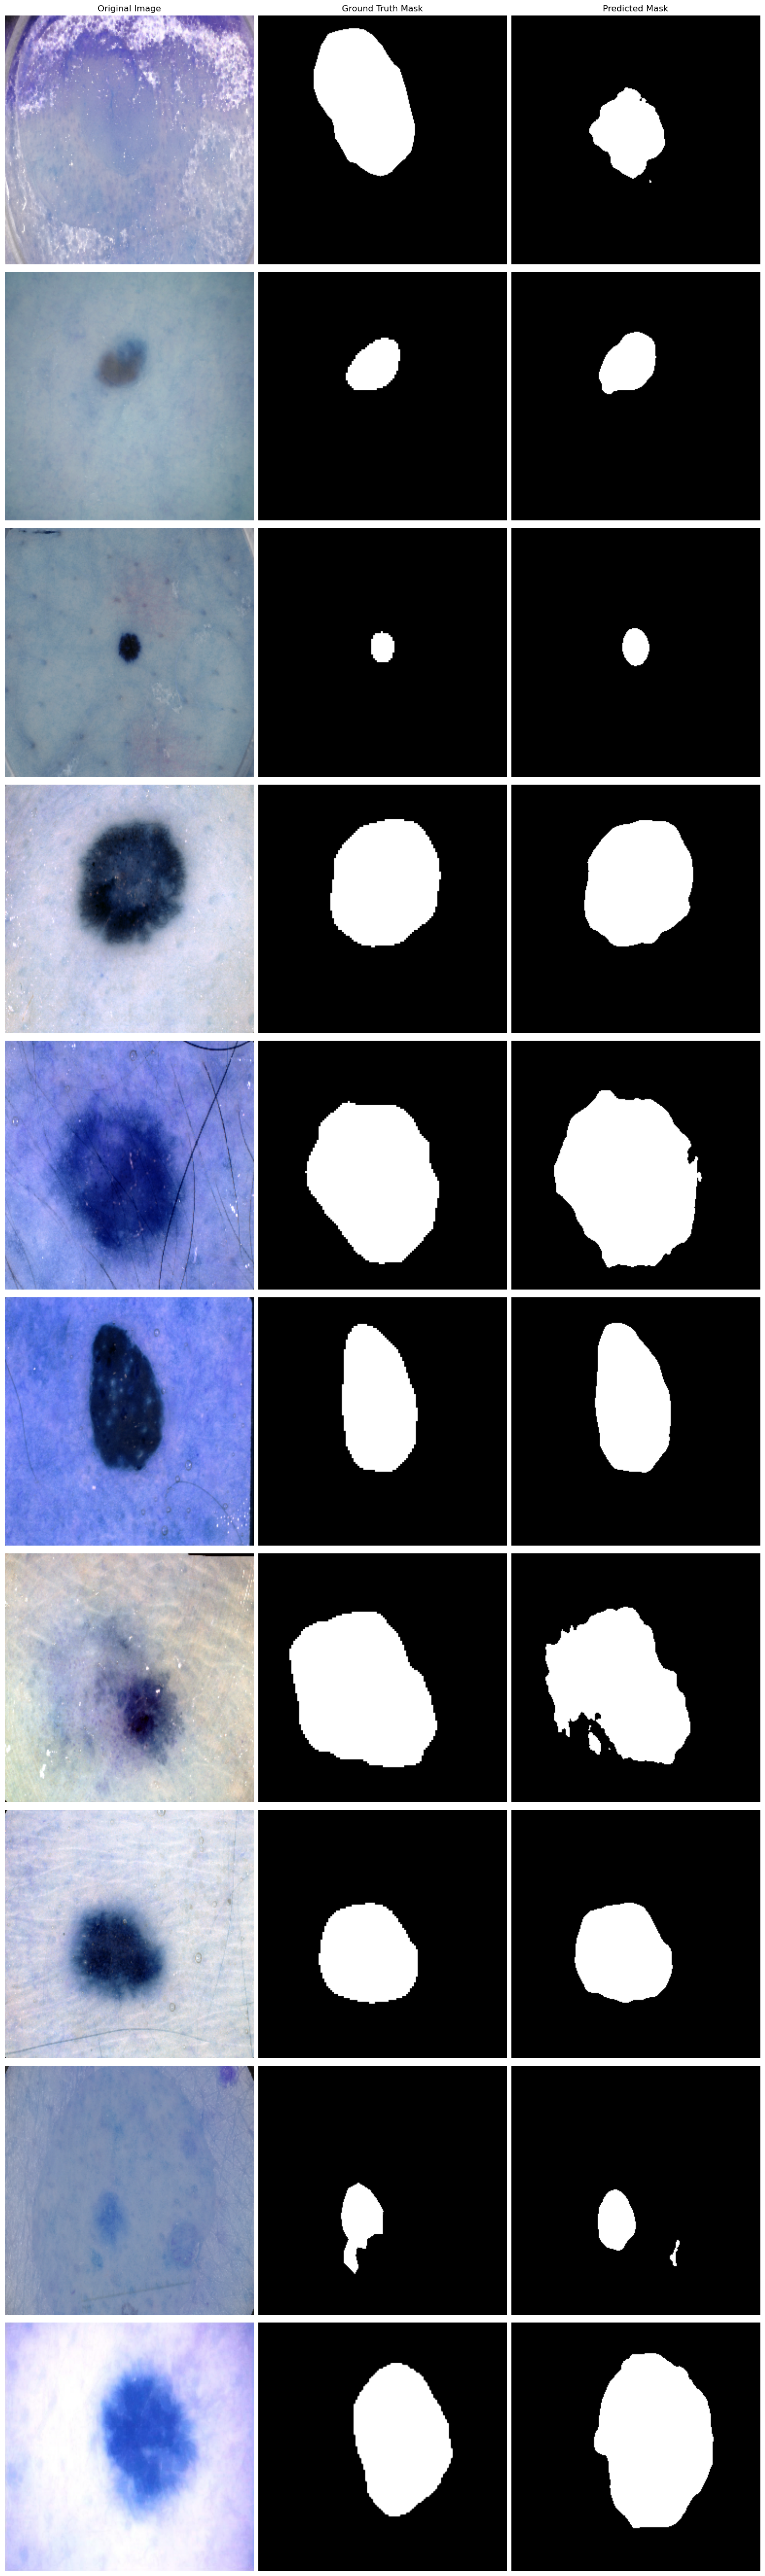

In [7]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Global parameters
H = 256
W = 256
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Test_Input_Cleaned"
test_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Test_GroundTruth"
model_path = "files/model.pth"

# Define SEResUNet class (must match main code)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class BatchNormReLU(nn.Module):
    def __init__(self, num_features):
        super(BatchNormReLU, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu2 = BatchNormReLU(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if strides != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, padding=0, bias=False)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn_relu1(x)
        x = self.conv2(x)
        x = self.bn_relu2(x)
        x = self.se(x)
        x = x + identity
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_channels = in_channels + skip_channels
        self.res_block = ResidualBlock(self.concat_channels, out_channels, strides=1)
        self.se = SEBlock(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        x = self.se(x)
        return x

class DensePPMBridge(nn.Module):
    def __init__(self, in_channels=256, out_channels=512):
        super(DensePPMBridge, self).__init__()
        growth_rate = 128

        self.dense1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=2, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )
        self.dense2 = nn.Sequential(
            nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )

        self.ppm_pool1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool2 = nn.Sequential(nn.AdaptiveAvgPool2d(2), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool3 = nn.Sequential(nn.AdaptiveAvgPool2d(3), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool6 = nn.Sequential(nn.AdaptiveAvgPool2d(6), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        
        self.final_conv = nn.Conv2d(in_channels + 2 * growth_rate + 4 * 128, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        d1 = self.dense1(x)
        d1_cat = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1], dim=1)
        d2 = self.dense2(d1_cat)
        dense_out = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1, d2], dim=1)

        ppm1 = self.ppm_pool1(dense_out)
        ppm1 = F.interpolate(ppm1, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm2 = self.ppm_pool2(dense_out)
        ppm2 = F.interpolate(ppm2, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm3 = self.ppm_pool3(dense_out)
        ppm3 = F.interpolate(ppm3, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm6 = self.ppm_pool6(dense_out)
        ppm6 = F.interpolate(ppm6, size=dense_out.size()[2:], mode='bilinear', align_corners=True)

        ppm_out = torch.cat([dense_out, ppm1, ppm2, ppm3, ppm6], dim=1)
        out = self.final_conv(ppm_out)
        return out

class SEResUNet(nn.Module):
    def __init__(self, input_shape=(256, 256, 3)):
        super(SEResUNet, self).__init__()
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.se1 = SEBlock(64)
        self.shortcut1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder2 = ResidualBlock(64, 128, strides=2)
        self.encoder3 = ResidualBlock(128, 256, strides=2)
        self.bridge = DensePPMBridge(256, 512)

        self.decoder1 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder3 = DecoderBlock(128, 64, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        s1 = self.conv1(x)
        s1 = self.bn_relu1(s1)
        s1 = self.conv2(s1)
        s1 = self.se1(s1)
        shortcut = self.shortcut1(x)
        s1 = s1 + shortcut

        s2 = self.encoder2(s1)
        s3 = self.encoder3(s2)
        b = self.bridge(s3)

        d1 = self.decoder1(b, s3)
        d2 = self.decoder2(d1, s2)
        d3 = self.decoder3(d2, s1)

        out = self.output(d3)
        out = self.sigmoid(out)
        return out

# Dataset class with preprocessing for test data
class ISICDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))  # Preprocessing: Resize to 256x256
        img = img / 255.0  # Preprocessing: Normalize to [0, 1]
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))  # Preprocessing: Channels first

        mask_path = self.masks[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))  # Preprocessing: Resize to 256x256
        mask = mask / 255.0  # Preprocessing: Normalize to [0, 1]
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Load test data
test_x = sorted(glob(os.path.join(test_image_dir, "*.jpg")))
test_y = sorted(glob(os.path.join(test_mask_dir, "*.png")))
test_dataset = ISICDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained model from model.pth
model = SEResUNet(input_shape=(H, W, 3)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Visualize 5 test images
num_images = 10
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Ground Truth Mask")
axes[0, 2].set_title("Predicted Mask")

for i, (images, masks) in enumerate(test_loader):
    if i >= num_images:
        break
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        y_pred = model(images)
        y_pred = (y_pred > 0.5).float()

    ori_x = images.cpu().numpy()[0].transpose(1, 2, 0) * 255.0  # Undo normalization for display
    ori_x = ori_x.astype(np.uint8)
    ori_y = masks.cpu().numpy()[0][0] * 255.0  # Undo normalization for display
    y_pred_np = y_pred.cpu().numpy()[0][0] * 255.0  # Scale to 0-255 for display

    axes[i, 0].imshow(ori_x)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(ori_y, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(y_pred_np, cmap='gray')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Test Accuracy: 0.9144
Test Dice Score: 0.8500
Test IoU: 0.7453


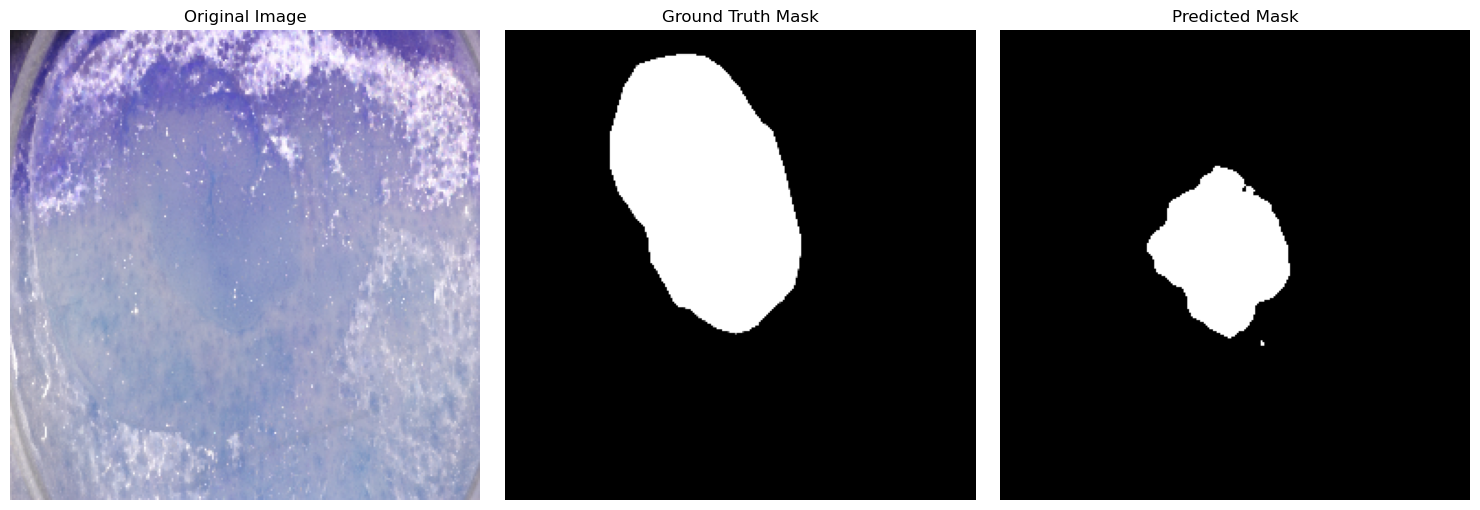

In [11]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Global parameters
H = 256
W = 256
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Test_Input_Cleaned"
test_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Test_GroundTruth"
model_path = "files/model.pth"

# Define SEResUNet class (must match main code)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class BatchNormReLU(nn.Module):
    def __init__(self, num_features):
        super(BatchNormReLU, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu2 = BatchNormReLU(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if strides != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, padding=0, bias=False)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn_relu1(x)
        x = self.conv2(x)
        x = self.bn_relu2(x)
        x = self.se(x)
        x = x + identity
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_channels = in_channels + skip_channels
        self.res_block = ResidualBlock(self.concat_channels, out_channels, strides=1)
        self.se = SEBlock(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        x = self.se(x)
        return x

class DensePPMBridge(nn.Module):
    def __init__(self, in_channels=256, out_channels=512):
        super(DensePPMBridge, self).__init__()
        growth_rate = 128

        self.dense1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=2, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )
        self.dense2 = nn.Sequential(
            nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )

        self.ppm_pool1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool2 = nn.Sequential(nn.AdaptiveAvgPool2d(2), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool3 = nn.Sequential(nn.AdaptiveAvgPool2d(3), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool6 = nn.Sequential(nn.AdaptiveAvgPool2d(6), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        
        self.final_conv = nn.Conv2d(in_channels + 2 * growth_rate + 4 * 128, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        d1 = self.dense1(x)
        d1_cat = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1], dim=1)
        d2 = self.dense2(d1_cat)
        dense_out = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1, d2], dim=1)

        ppm1 = self.ppm_pool1(dense_out)
        ppm1 = F.interpolate(ppm1, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm2 = self.ppm_pool2(dense_out)
        ppm2 = F.interpolate(ppm2, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm3 = self.ppm_pool3(dense_out)
        ppm3 = F.interpolate(ppm3, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm6 = self.ppm_pool6(dense_out)
        ppm6 = F.interpolate(ppm6, size=dense_out.size()[2:], mode='bilinear', align_corners=True)

        ppm_out = torch.cat([dense_out, ppm1, ppm2, ppm3, ppm6], dim=1)
        out = self.final_conv(ppm_out)
        return out

class SEResUNet(nn.Module):
    def __init__(self, input_shape=(256, 256, 3)):
        super(SEResUNet, self).__init__()
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.se1 = SEBlock(64)
        self.shortcut1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder2 = ResidualBlock(64, 128, strides=2)
        self.encoder3 = ResidualBlock(128, 256, strides=2)
        self.bridge = DensePPMBridge(256, 512)

        self.decoder1 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder3 = DecoderBlock(128, 64, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        s1 = self.conv1(x)
        s1 = self.bn_relu1(s1)
        s1 = self.conv2(s1)
        s1 = self.se1(s1)
        shortcut = self.shortcut1(x)
        s1 = s1 + shortcut

        s2 = self.encoder2(s1)
        s3 = self.encoder3(s2)
        b = self.bridge(s3)

        d1 = self.decoder1(b, s3)
        d2 = self.decoder2(d1, s2)
        d3 = self.decoder3(d2, s1)

        out = self.output(d3)
        out = self.sigmoid(out)
        return out

# Dataset class with preprocessing for test data
class ISICDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))  # Preprocessing: Resize to 256x256
        img = img / 255.0  # Preprocessing: Normalize to [0, 1]
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))  # Preprocessing: Channels first

        mask_path = self.masks[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))  # Preprocessing: Resize to 256x256
        mask = mask / 255.0  # Preprocessing: Normalize to [0, 1]
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Metrics functions
def dice_coef(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

def iou(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(y_pred, y_true):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    correct = (y_pred == y_true).float().sum()
    total = y_true.numel()
    return correct / total

# Load test data
test_x = sorted(glob(os.path.join(test_image_dir, "*.jpg")))
test_y = sorted(glob(os.path.join(test_mask_dir, "*.png")))
test_dataset = ISICDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained model from model.pth
model = SEResUNet(input_shape=(H, W, 3)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Calculate test metrics
test_dice = 0.0
test_iou = 0.0
test_acc = 0.0
total_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        y_pred = model(images)
        y_pred_binary = (y_pred > 0.5).float()  # Binarize predictions for metrics

        batch_size = images.size(0)
        total_samples += batch_size

        test_dice += dice_coef(y_pred_binary, masks).item() * batch_size
        test_iou += iou(y_pred_binary, masks).item() * batch_size
        test_acc += accuracy(y_pred_binary, masks).item() * batch_size

# Average the metrics over the dataset
test_dice /= total_samples
test_iou /= total_samples
test_acc /= total_samples

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")

# Visualize 10 test images
# Visualize test images
num_images = 1  # You can change this to any number
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

# Handle the case when num_images = 1 (axes is 1D)
if num_images == 1:
    axes = np.array([axes])  # Convert to 2D array for consistent indexing

# Set titles for the first row
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Ground Truth Mask")
axes[0, 2].set_title("Predicted Mask")

for i, (images, masks) in enumerate(test_loader):
    if i >= num_images:
        break
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        y_pred = model(images)
        y_pred = (y_pred > 0.5).float()

    ori_x = images.cpu().numpy()[0].transpose(1, 2, 0) * 255.0  # Undo normalization for display
    ori_x = ori_x.astype(np.uint8)
    ori_y = masks.cpu().numpy()[0][0] * 255.0  # Undo normalization for display
    y_pred_np = y_pred.cpu().numpy()[0][0] * 255.0  # Scale to 0-255 for display

    axes[i, 0].imshow(ori_x)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(ori_y, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(y_pred_np, cmap='gray')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import os
import glob

def remove_hair(input_image_path, output_image_path):
    # Load the image
    image = cv2.imread(input_image_path)
    if image is None:
        print(f"Error: Unable to load image from {input_image_path}")
        return
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply BlackHat Morphological Operation to detect hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Apply Thresholding to create a binary mask
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Apply Inpainting to remove the hair
    cleaned_image = cv2.inpaint(image, mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_image_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the cleaned image and verify
    success = cv2.imwrite(output_image_path, cleaned_image)
    if success:
        print(f"Output image saved at: {output_image_path}")
    else:
        print("Error: Image saving failed.")

# # Define input and output directories
# input_folder = r"E:\Code\ClassPlusSeg\ISIC2018_Task1-2_Training_Input"
# output_folder = r"E:\Code\ClassPlusSeg\Cleaned_Images"

# Get all image files in input folder
image_files = glob.glob(os.path.join(input_folder, "*.jpg"))  # Modify if images have different extensions

# Process each image
for image_path in image_files:
    # Extract image filename
    image_filename = os.path.basename(image_path)
    
    # Define output path for the cleaned image
    output_image_path = os.path.join(output_folder, f"cleaned_{image_filename}")

    # Remove hair and save the image
    remove_hair(image_path, output_image_path)


In [ ]:
# Import necessary libraries
import os
import sys
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

train_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Training_Input_Cleaned"
train_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Training_GroundTruth"
val_image_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1-2_Validation_Input_Cleaned"
val_mask_dir = "E:/Code/ClassPlusSeg/ISIC2018_Task1_Validation_GroundTruth"

# Global parameters
H = 256
W = 256
batch_size = 16
lr = 1e-4
num_epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- SE Block Definition ---
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- BatchNormReLU ---
class BatchNormReLU(nn.Module):
    def __init__(self, num_features):
        super(BatchNormReLU, self).__init__()
        self.bn = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        return x

# --- Residual Block with SE ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu2 = BatchNormReLU(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if strides != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, padding=0, bias=False)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn_relu1(x)
        x = self.conv2(x)
        x = self.bn_relu2(x)
        x = self.se(x)
        x = x + identity
        return x

# --- Decoder Block with SE ---
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_channels = in_channels + skip_channels
        self.res_block = ResidualBlock(self.concat_channels, out_channels, strides=1)
        self.se = SEBlock(out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        x = self.se(x)
        return x

# --- Dense PPM Bridge (Fixed Bottleneck) ---
class DensePPMBridge(nn.Module):
    def __init__(self, in_channels=256, out_channels=512):
        super(DensePPMBridge, self).__init__()
        growth_rate = 128  # Growth rate for dense connections

        # Dense Block with stride=2 to reduce spatial size
        self.dense1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=2, padding=1, bias=False),  # 64x64 → 32x32
            BatchNormReLU(growth_rate)
        )
        self.dense2 = nn.Sequential(
            nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            BatchNormReLU(growth_rate)
        )

        # PPM
        self.ppm_pool1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool2 = nn.Sequential(nn.AdaptiveAvgPool2d(2), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool3 = nn.Sequential(nn.AdaptiveAvgPool2d(3), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        self.ppm_pool6 = nn.Sequential(nn.AdaptiveAvgPool2d(6), nn.Conv2d(in_channels + 2 * growth_rate, 128, 1, bias=False), BatchNormReLU(128))
        
        # Final convolution to match out_channels
        self.final_conv = nn.Conv2d(in_channels + 2 * growth_rate + 4 * 128, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        # Dense Block
        d1 = self.dense1(x)  # 32x32x128
        d1_cat = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1], dim=1)  # Downsample x to 32x32
        d2 = self.dense2(d1_cat)  # 32x32x128
        dense_out = torch.cat([F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True), d1, d2], dim=1)  # 32x32x(256+128+128=512)

        # PPM
        ppm1 = self.ppm_pool1(dense_out)
        ppm1 = F.interpolate(ppm1, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm2 = self.ppm_pool2(dense_out)
        ppm2 = F.interpolate(ppm2, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm3 = self.ppm_pool3(dense_out)
        ppm3 = F.interpolate(ppm3, size=dense_out.size()[2:], mode='bilinear', align_corners=True)
        ppm6 = self.ppm_pool6(dense_out)
        ppm6 = F.interpolate(ppm6, size=dense_out.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate PPM outputs
        ppm_out = torch.cat([dense_out, ppm1, ppm2, ppm3, ppm6], dim=1)  # 32x32x(512+128*4=1024)
        out = self.final_conv(ppm_out)  # 32x32x512
        return out

# --- Updated SE-ResUNet Model ---
class SEResUNet(nn.Module):
    def __init__(self, input_shape=(256, 256, 3)):
        super(SEResUNet, self).__init__()
        self.input_shape = input_shape

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_relu1 = BatchNormReLU(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.se1 = SEBlock(64)
        self.shortcut1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder2 = ResidualBlock(64, 128, strides=2)
        self.encoder3 = ResidualBlock(128, 256, strides=2)
        self.bridge = DensePPMBridge(256, 512)  # Updated bottleneck

        self.decoder1 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder3 = DecoderBlock(128, 64, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        s1 = self.conv1(x)
        s1 = self.bn_relu1(s1)
        s1 = self.conv2(s1)
        s1 = self.se1(s1)
        shortcut = self.shortcut1(x)
        s1 = s1 + shortcut  # 256x256x64

        s2 = self.encoder2(s1)  # 128x128x128
        s3 = self.encoder3(s2)  # 64x64x256
        b = self.bridge(s3)     # 32x32x512

        d1 = self.decoder1(b, s3)  # 64x64x256
        d2 = self.decoder2(d1, s2) # 128x128x128
        d3 = self.decoder3(d2, s1) # 256x256x64

        out = self.output(d3)
        out = self.sigmoid(out)
        return out

# --- Metrics and Utility Functions ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-15):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1.0 - dice

def dice_coef(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

def iou(y_pred, y_true, smooth=1e-15):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Created directory: {path}")
        else:
            print(f"Directory already exists: {path}")
    except OSError as e:
        print(f"Error creating directory {path}: {e}")
        raise

def load_data():
    train_images = sorted(glob(os.path.join(train_image_dir, "*.jpg")))
    train_masks = sorted(glob(os.path.join(train_mask_dir, "*.png")))
    val_images = sorted(glob(os.path.join(val_image_dir, "*.jpg")))
    val_masks = sorted(glob(os.path.join(val_mask_dir, "*.png")))
    train_x, test_x, train_y, test_y = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)
    valid_x, valid_y = val_images, val_masks
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

class ISICDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        img = img / 255.0
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))

        mask_path = self.masks[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))
        mask = mask / 255.0
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

def save_result(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255.0
    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0
    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

# --- Main Execution ---
np.random.seed(42)
torch.manual_seed(42)

create_dir("files")
create_dir("results")

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()
train_x, train_y = shuffle(train_x, train_y, random_state=42)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = ISICDataset(train_x, train_y)
valid_dataset = ISICDataset(valid_x, valid_y)
test_dataset = ISICDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = SEResUNet(input_shape=(H, W, 3)).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
best_val_loss = float('inf')
model_path = os.path.join("files", "model.pth")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_bar.set_postfix({"Train Loss": loss.item()})
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            outputs = (outputs > 0.5).float()
            val_dice += dice_coef(outputs, masks).item() * images.size(0)
            val_iou += iou(outputs, masks).item() * images.size(0)
            val_bar.set_postfix({"Val Loss": loss.item()})
    
    val_loss /= len(valid_loader.dataset)
    val_dice /= len(valid_loader.dataset)
    val_iou /= len(valid_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        create_dir("files")
        torch.save(model.state_dict(), model_path)
        print(f"Saved best model at epoch {epoch+1}")

# Evaluation with Dice and IoU
model.eval()
SCORE = []
for i, (images, masks) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating"):
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        y_pred = model(images)
        y_pred = (y_pred > 0.5).float()

    ori_x = images.cpu().numpy()[0].transpose(1, 2, 0) * 255.0
    ori_x = ori_x.astype(np.uint8)
    ori_y = masks.cpu().numpy()[0][0] * 255.0
    y_pred_np = y_pred.cpu().numpy()[0][0]

    name = test_x[i].split("\\")[-1]
    save_image_path = f"results/{name}"
    save_result(ori_x, ori_y, y_pred_np, save_image_path)

    y_true = masks.cpu().numpy().flatten()
    y_pred_flat = y_pred.cpu().numpy().flatten()
    y_true = (y_true > 0.5).astype(np.int32)
    y_pred_flat = y_pred_flat.astype(np.int32)

    acc_value = accuracy_score(y_true, y_pred_flat)
    f1_value = f1_score(y_true, y_pred_flat, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y_true, y_pred_flat, labels=[0, 1], average="binary")
    recall_value = recall_score(y_true, y_pred_flat, labels=[0, 1], average="binary")
    precision_value = precision_score(y_true, y_pred_flat, labels=[0, 1], average="binary")
    dice_value = dice_coef(y_pred, masks).item()
    iou_value = iou(y_pred, masks).item()

    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, dice_value, iou_value])

score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Dice: {score[5]:0.5f}")
print(f"IoU: {score[6]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision", "Dice", "IoU"])
df.to_csv("files/score.csv")

In [ ]:
import matplotlib.pyplot as plt

# Load the trained model
model = SEResUNet(input_shape=(H, W, 3)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Visualize 5 test images
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Ground Truth Mask")
axes[0, 2].set_title("Predicted Mask")

for i, (images, masks) in enumerate(test_loader):
    if i >= num_images:
        break
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        y_pred = model(images)
        y_pred = (y_pred > 0.5).float()

    ori_x = images.cpu().numpy()[0].transpose(1, 2, 0) * 255.0
    ori_x = ori_x.astype(np.uint8)
    ori_y = masks.cpu().numpy()[0][0] * 255.0
    y_pred_np = y_pred.cpu().numpy()[0][0] * 255.0

    axes[i, 0].imshow(ori_x)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(ori_y, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(y_pred_np, cmap='gray')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()